In [21]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import matplotlib.pyplot as plt

In [22]:
tsla_filepath = os.path.join(os.getcwd(), 'tsla.csv')
goog_filepath = os.path.join(os.getcwd(), 'goog.csv')
eth_filepath = os.path.join(os.getcwd(), 'eth.csv')
btc_filepath = os.path.join(os.getcwd(), 'btc.csv')

tsla_df = pd.read_csv(tsla_filepath)
goog_df = pd.read_csv(goog_filepath)
eth_df = pd.read_csv(eth_filepath)
btc_df = pd.read_csv(btc_filepath)

In [23]:
# Function to clean data
def clean_data(df):
    df = df[['Date', 'Close']]  # Select only the 'Date' and the 'Close' column
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
    df = df.dropna().reset_index(drop=True)  # Drop rows with NaN and reset the index

    return df

In [24]:
tsla_df = clean_data(tsla_df)
goog_df = clean_data(goog_df)
eth_df = clean_data(eth_df)
btc_df = clean_data(btc_df)

<ipython-input-23-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
<ipython-input-23-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
<ipython-input-23-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [25]:
# Function to preprocess data (splitting, scaling, and preparing training data)
def preprocess_data(data, train_split=0.7, window_size=100):
    # Splitting the data into training and testing
    data_training = data[0:int(len(data) * train_split)]
    data_testing = data[int(len(data) * train_split):]

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_training_array = scaler.fit_transform(data_training)

    # Preparing training data
    x_train, y_train = [], []
    for i in range(window_size, len(data_training_array)):
        x_train.append(data_training_array[i - window_size:i])
        y_train.append(data_training_array[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    return x_train, y_train, data_testing, scaler

In [26]:
# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [27]:
# Function to prepare test data
def prepare_test_data(data_testing, data_training, scaler, window_size=100):
    past_data = data_training.tail(window_size)
    final_data = pd.concat([past_data, data_testing], ignore_index=True)
    input_data = scaler.transform(final_data)

    x_test, y_test = [], []
    for i in range(window_size, len(input_data)):
        x_test.append(input_data[i - window_size:i])
        y_test.append(input_data[i, 0])

    x_test, y_test = np.array(x_test), np.array(y_test)
    return x_test, y_test

In [49]:
# Function to plot predictions with proper x-axis handling
def plot_predictions(y_test, y_predicted, scaler, test_dates, tick_interval=365):
    # Reverse scaling
    scale_factor = 1 / scaler.scale_[0]
    y_test = y_test * scale_factor
    y_predicted = y_predicted * scale_factor

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Original Price', linewidth=1)
    plt.plot(test_dates, y_predicted, label='Predicted Price', linewidth=1)

    # Formatting x-axis
    plt.xlabel('Date')  # Label for x-axis
    plt.ylabel('Price (USD)')  # Label for y-axis
    plt.title('Predicted Price vs. Actual Price')  # Add a title

    # Ensure evenly spaced x-axis ticks
    plt.xticks(test_dates[::tick_interval])  # Show every tick_interval-th date

    # Adjust x-axis limits
    plt.xlim(test_dates.iloc[0], test_dates.iloc[-1])  # Ensure the plot spans all dates

    # Add legend and show the plot
    plt.legend()
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

In [50]:
# Main function to train and test the model for a given stock
def train_and_test_lstm(stock_data, epochs=10, window_size=100):
    # Preprocessing the data
    x_train, y_train, data_testing, scaler = preprocess_data(stock_data[['Close']], window_size=window_size)

    # Building the model
    model = build_lstm_model((x_train.shape[1], 1))
    model.fit(x_train, y_train, epochs=epochs, batch_size=32)

    # Preparing test data
    x_test, y_test = prepare_test_data(data_testing, stock_data[['Close']], scaler, window_size=window_size)

    # Making predictions
    y_predicted = model.predict(x_test)

    # Extracting test dates
    test_dates = pd.to_datetime(stock_data.iloc[-len(data_testing):]['Date']).reset_index(drop=True)

    # Return the results
    return y_test, y_predicted, scaler, test_dates, model

In [47]:
def predict_future_prices(model, stock_data, scaler, last_window, prediction_intervals, frequency='Month'):
    future_predictions = []
    future_dates = []

    # Define the step size based on the frequency
    if frequency == 'Day':
        step_size = 1  # Daily
    elif frequency == 'Week':
        step_size = 7  # Weekly
    elif frequency == 'Month':
        step_size = 30  # Monthly
    else:
        raise ValueError("Invalid frequency. Use 'Day', 'Week', or 'Month'.")

    # Start from the last known date
    start_date = pd.to_datetime(stock_data['Date'].iloc[-1])

    # Calculate the number of prediction steps
    max_steps = max(prediction_intervals) // step_size

    # Predict iteratively for the required number of steps
    for step in range(max_steps):
        # Predict the next step
        next_prediction = model.predict(last_window, verbose=0)  # Suppress logging

        # Append the prediction (normalized value)
        future_predictions.append(next_prediction[0, 0])

        # Update the last_window with the new prediction
        last_window = np.append(last_window[:, 1:, :], [[[next_prediction[0, 0]]]], axis=1)

        # Append the corresponding date
        future_dates.append(start_date + pd.Timedelta(days=(step + 1) * step_size))

    # Reverse scale the predictions back to the original scale
    future_predictions = np.array(future_predictions) * (1 / scaler.scale_[0])

    # Filter predictions and dates based on specified intervals
    filtered_predictions = {
        interval: future_predictions[: interval // step_size] for interval in prediction_intervals
    }
    filtered_dates = {
        interval: future_dates[: interval // step_size] for interval in prediction_intervals
    }

    # Plot the predictions for each interval
    plt.figure(figsize=(12, 6))
    for interval in prediction_intervals:
        plt.plot(
            filtered_dates[interval],
            filtered_predictions[interval],
            label=f'Next {interval} {frequency.lower()}s',
            linewidth=1,
        )

    # Formatting the plot
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title('Future Stock Price Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return filtered_predictions, filtered_dates

In [31]:
# Train the model and get data
tsla_y_test, tsla_y_predicted, tsla_scaler, tsla_test_dates, tsla_model = train_and_test_lstm(tsla_df, epochs=10, window_size=100)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.0093
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0014
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0011
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0013
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0016
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0013
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0013
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0011
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0014
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0016
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


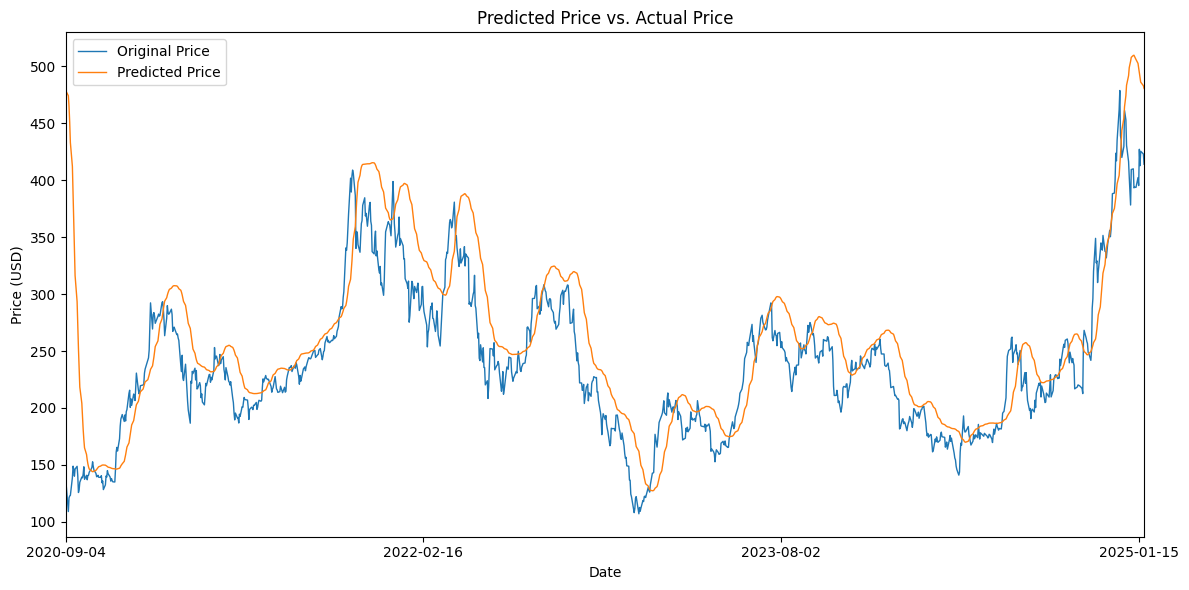

In [51]:
# Plot predictions (adjust tick_interval as needed, e.g., every 365 days)
plot_predictions(tsla_y_test, tsla_y_predicted, tsla_scaler, tsla_test_dates, tick_interval=365)

In [52]:
intervals = [30, 180, 3650]  # Days for 1 month, 6 months, and 10 years

# Prepare the last window of data
window_size = 100
tsla_last_window = tsla_df['Close'].iloc[-window_size:].values.reshape(1, window_size, 1)

filtered_predictions, filtered_dates = predict_future_prices(
    model=tsla_model,
    stock_data=tsla_df,
    scaler=tsla_scaler,
    last_window=tsla_last_window,
    prediction_intervals=intervals,
    frequency='Month',  # Monthly predictions
)

ValueError: Invalid frequency. Use 'Day', 'Week', or 'Month'.

In [34]:
goog_y_test, goog_y_predicted, goog_scaler, goog_test_dates, goog_model = train_and_test_lstm(goog_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0437
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0054
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0045
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0032
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0037
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0035
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0034
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0027
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0031
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0024
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


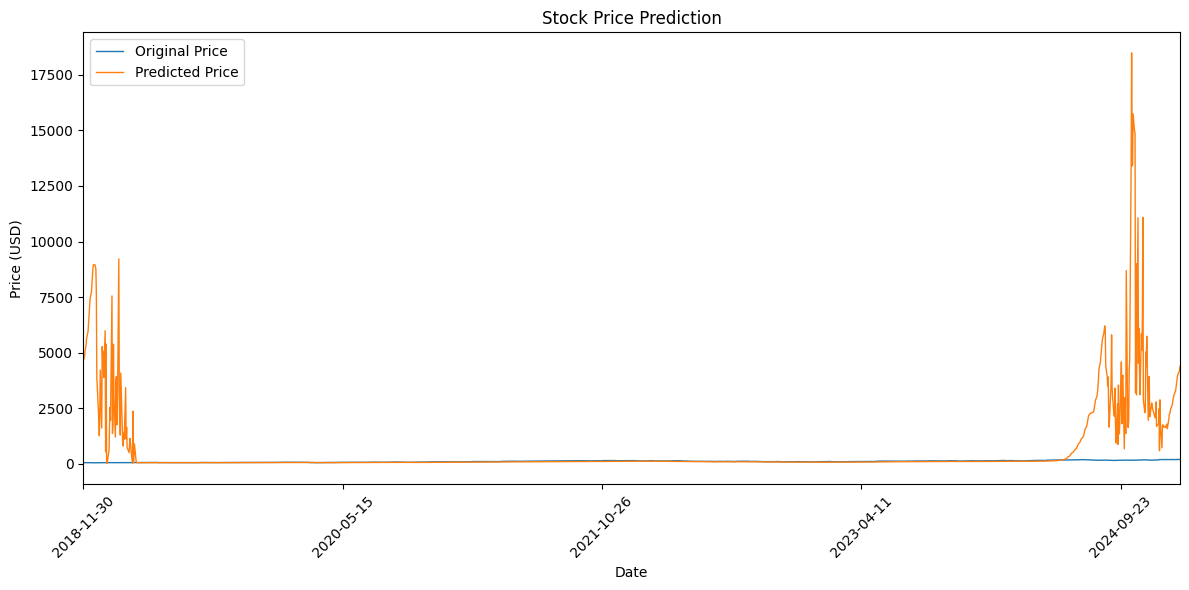

In [44]:
plot_predictions(goog_y_test, goog_y_predicted, goog_scaler, goog_test_dates, tick_interval=365)

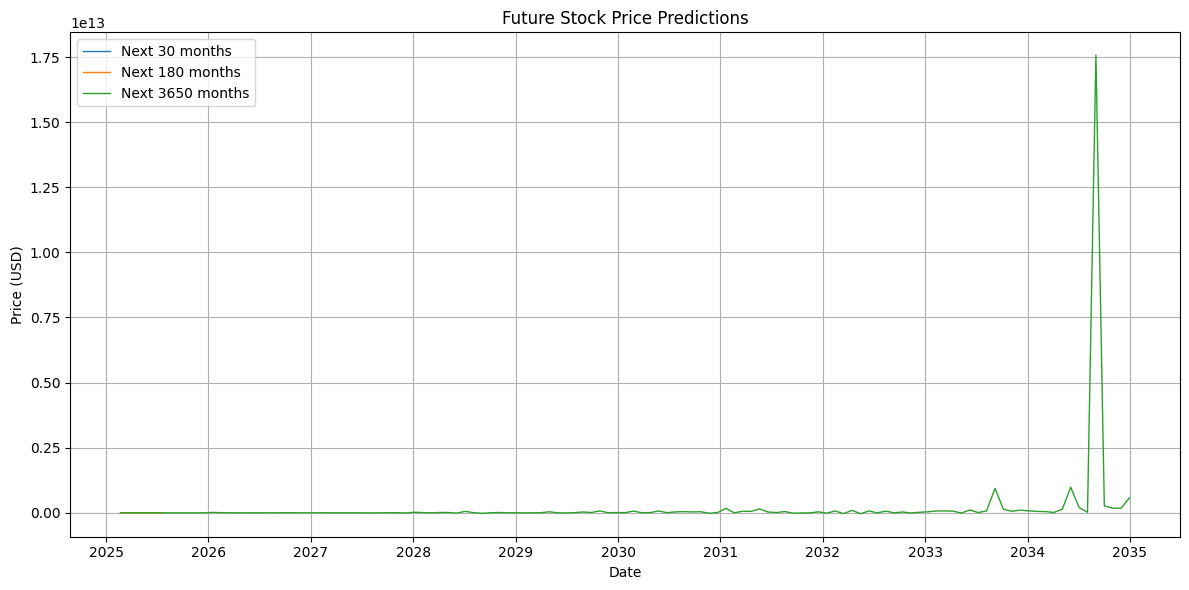

In [53]:
# Prepare the last window of data
goog_last_window = goog_df['Close'].iloc[-window_size:].values.reshape(1, window_size, 1)

filtered_predictions, filtered_dates = predict_future_prices(
    model=goog_model,
    stock_data=goog_df,
    scaler=goog_scaler,
    last_window=goog_last_window,
    prediction_intervals=intervals,
    frequency='Month',  # Monthly predictions
)

In [37]:
eth_y_test, eth_y_predicted, eth_scaler, eth_test_dates, eth_model = train_and_test_lstm(eth_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - loss: 0.0573
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0087
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0073
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0070
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0061
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0057
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0052
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0042
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0047
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0045
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


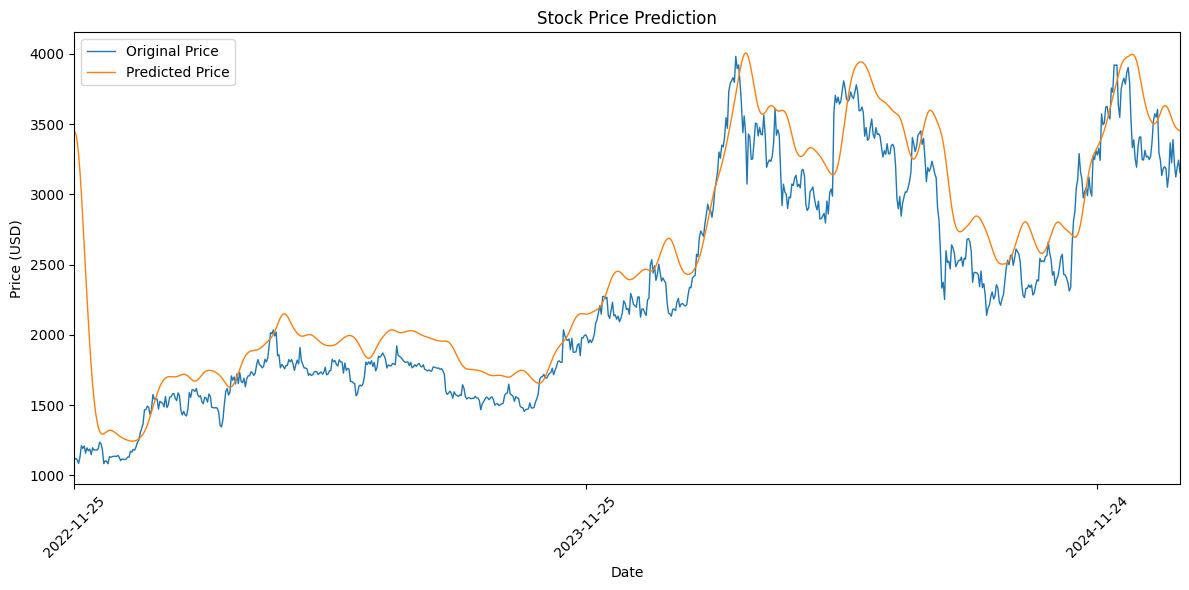

In [38]:
plot_predictions(eth_y_test, eth_y_predicted, eth_scaler, eth_test_dates, tick_interval=365)

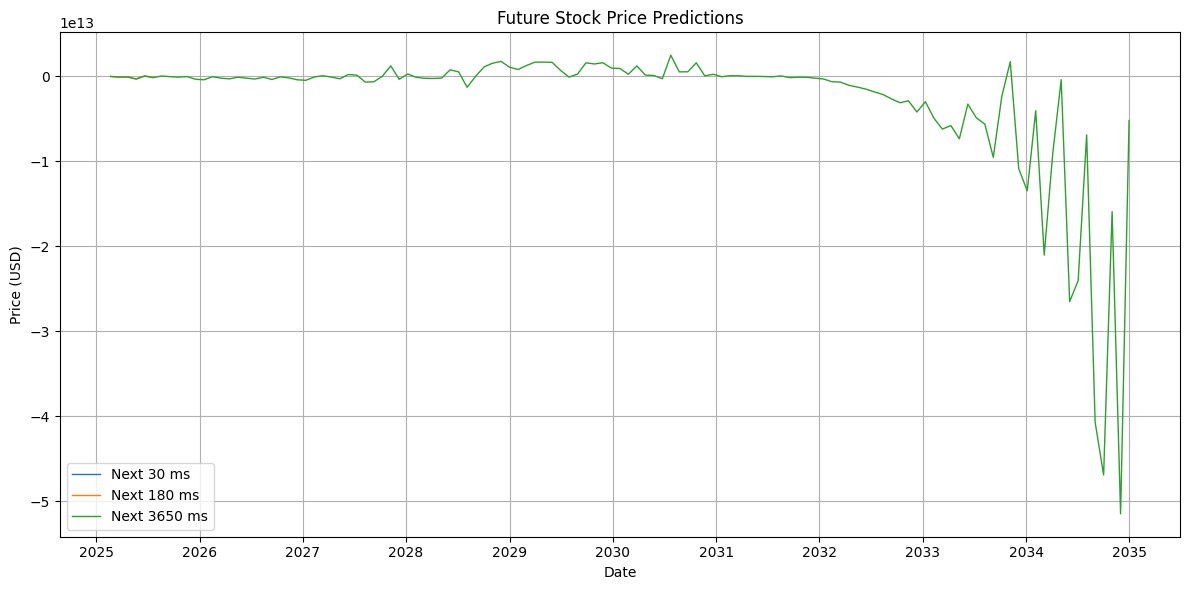

In [39]:
# Prepare the last window of data
eth_last_window = btc_df['Close'].iloc[-window_size:].values.reshape(1, window_size, 1)

filtered_predictions, filtered_dates = predict_future_prices(
    model=eth_model,
    stock_data=eth_df,
    scaler=eth_scaler,
    last_window=eth_last_window,
    prediction_intervals=intervals,
    frequency='Month',  # Monthly predictions
)

In [40]:
btc_y_test, btc_y_predicted, btc_scaler, btc_test_dates, btc_model = train_and_test_lstm(btc_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - loss: 0.1730
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0098
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0050
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0047
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0037
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0037
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0032
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0033
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0035
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0028
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


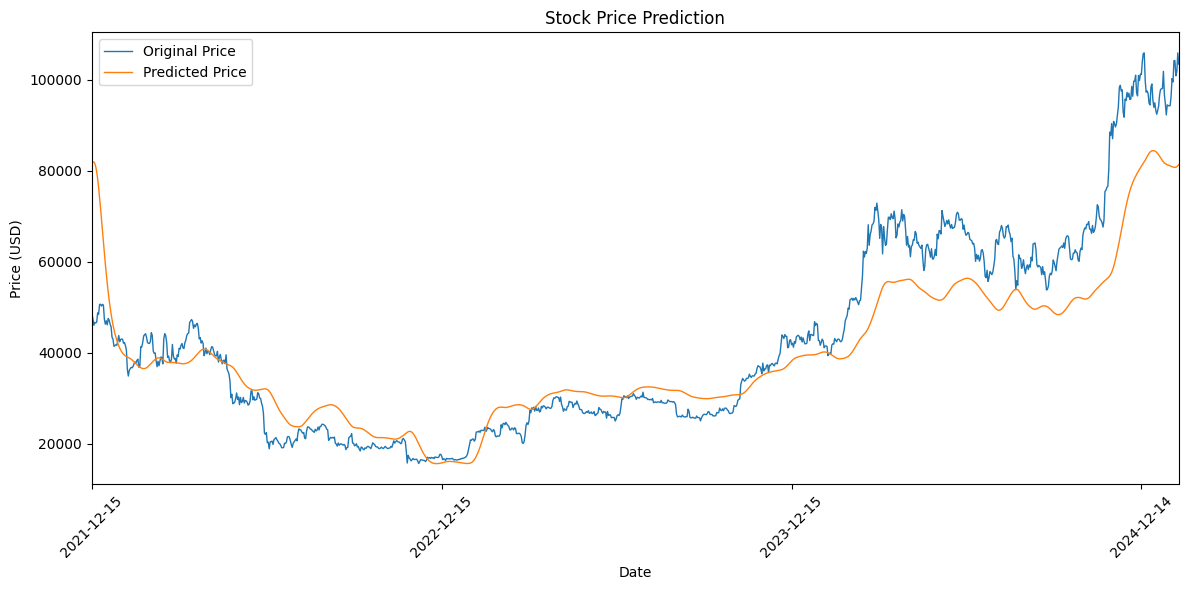

In [41]:
plot_predictions(btc_y_test, btc_y_predicted, btc_scaler, btc_test_dates, tick_interval=365)

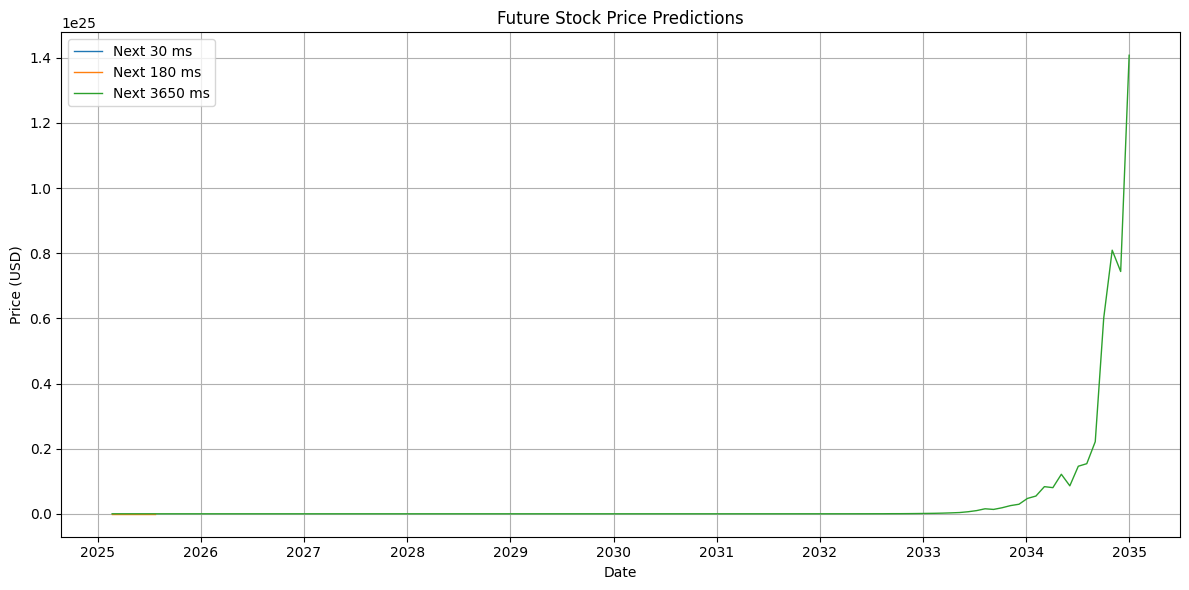

In [42]:
# Prepare the last window of data
btc_last_window = btc_df['Close'].iloc[-window_size:].values.reshape(1, window_size, 1)

filtered_predictions, filtered_dates = predict_future_prices(
    model=btc_model,
    stock_data=btc_df,
    scaler=btc_scaler,
    last_window=btc_last_window,
    prediction_intervals=intervals,
    frequency='Month',  # Monthly predictions
)